In [5]:
import os
import glob
import pandas as pd
import shutil


from IPython.display import display
from PIL import Image

In [14]:
# Follow README.md to install dependencies and setup environment with Broden dataset

# Set paths
MODIFIED_DATA_DIR = "./dataset/broden1_224_modified"
OUTPUT_DIR = "./output"

# Remove old modified data and output files
if os.path.exists(MODIFIED_DATA_DIR):
    shutil.rmtree(MODIFIED_DATA_DIR)
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)

# Set CUDA device id
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [20]:
# Common functions
def resolve_file(filter_string):
    files = glob.glob(filter_string)
    if len(files) != 1:
        raise Exception(f"Error: {len(files)} files found for {filter_string}")
    return files[0]

def move_tally_file(experiment, model, dataset, layer)
    tally_filter = f"./output/{experiment}/{model}/{dataset}/{layer}/baseline/*/tally.csv"
    tally_file = resolve_file(tally_filter)
    assert os.path.exists(tally_file)

    dest_dir = f"./tally/{model}/{dataset}/{layer}"
    os.makedirs(dest_dir, exist_ok=True)
    shutil.copy(tally_file, dest_dir)

def visualize_baseline_results(experiment, model, dataset, layer, unit):
    # setup baseline filter
    baseline_filter = f"./output/{experiment}/{model}/{dataset}/{layer}/baseline/*"

    # Get tally file
    tally_file_filter = f"{baseline_filter}/tally.csv"
    tally_file = resolve_file(tally_file_filter)

    # Get assigned concept
    tally = pd.read_csv(tally_file)
    sorted_tally = tally.sort_values(by=['unit'], ascending=True)
    print("Assigned concept: ", sorted_tally.iloc[unit]['label'], "   IOU: ", round(sorted_tally.iloc[unit]['score'], 2))

    # Get visualization file
    visualization_file_filter = f"{baseline_filter}/html/image/{layer}-0{unit}_original.jpg"
    visualization_file = resolve_file(visualization_file_filter)

    # Visualize
    img = Image.open(visualization_file)
    print("Top Activating images (Row1) and activation mask (Row2)")
    display(img)


def visualize_modified_results(experiment, model, dataset, layer, unit, category, name, eps):
    # Setup baseline filter
    baseline_filter = f"./output/{experiment}_modified/{model}/{dataset}/{layer}/concept_attack/source_unit_{unit}/method_pgd/epsilon_{eps}/steps_10/target_{category}/target_name_{name}/*"
    
    # Get tally file
    tally_file_filter = f"{baseline_filter}/tally.csv"
    tally_file = resolve_file(tally_file_filter)

    # Get assigned concept
    tally = pd.read_csv(tally_file)
    assert len(tally) == 1
    print("Modified concept: ", tally.iloc[0]['label'], "   IOU: ", round(tally.iloc[0]['score'], 2))

    # Get visualization file
    visualization_file_filter = f"{baseline_filter}/html/image/{layer}-0000_original.jpg"
    visualization_file = resolve_file(visualization_file_filter)

    # Visualize
    img = Image.open(visualization_file)
    print("Top Activating images (Row1) and activation mask (Row2)")
    display(img)

# Generate concepts for neurons in conv5_3 layer of VGG16-Places365
The entrypoint for the script is the `main.py` file. We will use the following command to call this script and generate the concepts for neurons in `conv5_3` layer of the VGG16-Places365 model.

```bash
python3 main.py --model vgg16 --dataset places365 --layer conv5_3 --experiment_name baseline
```

This command will generate a tally file with the concepts in the `conv5_3` layer of the VGG16-Places365 model. The tally file is needed to modify the neuron concepts and must be present under `./tally/vgg16/places365/conv5_3` foder.

Note: The indexing for the neurons starts from 0. So, the first neuron is indexed as 0, the second neuron is indexed as 1 and so on. **Note**: This command can take upto an hour to complete depending on your system since we are computing concept for all neurons in the layer.

In [40]:
# Run baseline experiment
!python3 main.py --model vgg16 --dataset places365 --layer conv5_3 --experiment_name baseline

In [41]:
# move tally files
move_tally_file("baseline", "vgg16", "places365", "conv5_3")

## Visualize original concept of neuron 191

Assigned concept:  bus    IOU:  0.15
Top Activating images (Row1) and activation mask (Row2)


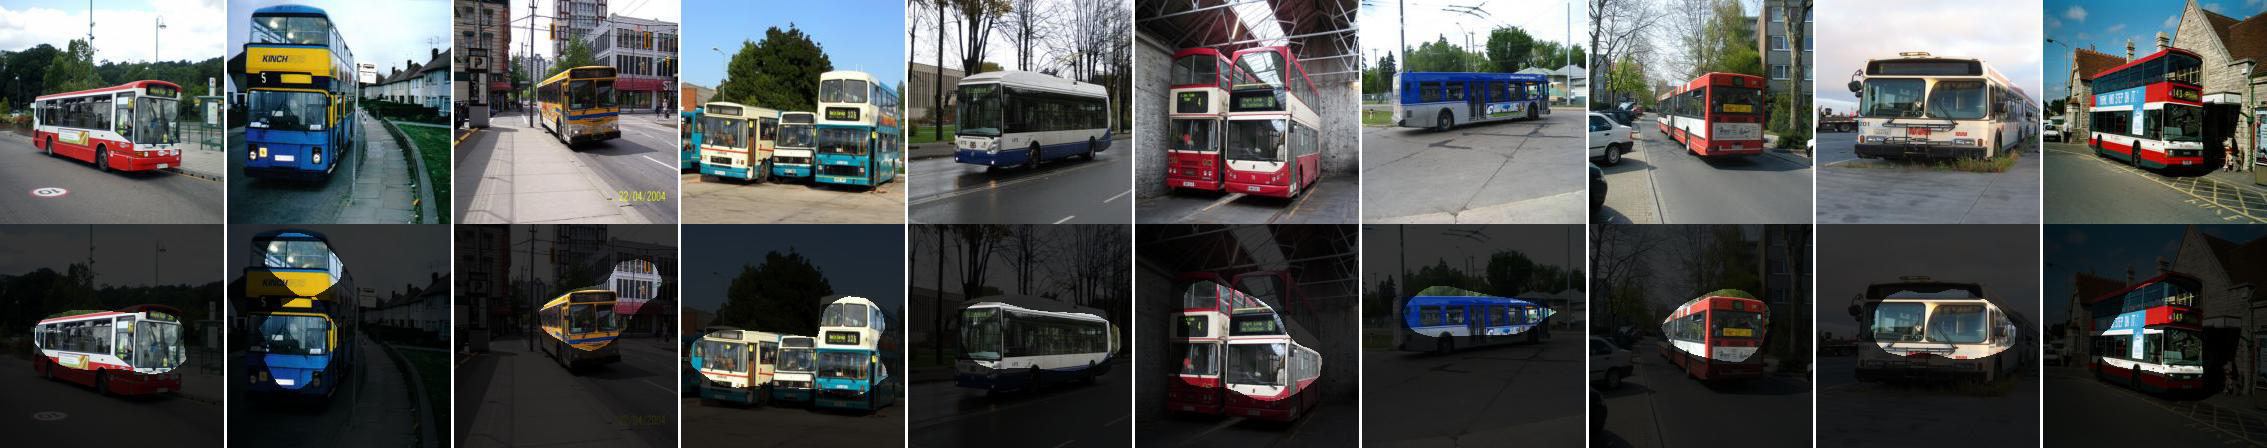

In [21]:
visualize_baseline_results("baseline", "vgg16", "places365", "conv5_3", 190)

## Visualize original concept of neuron 482

Assigned concept:  pot    IOU:  0.07
Top Activating images (Row1) and activation mask (Row2)


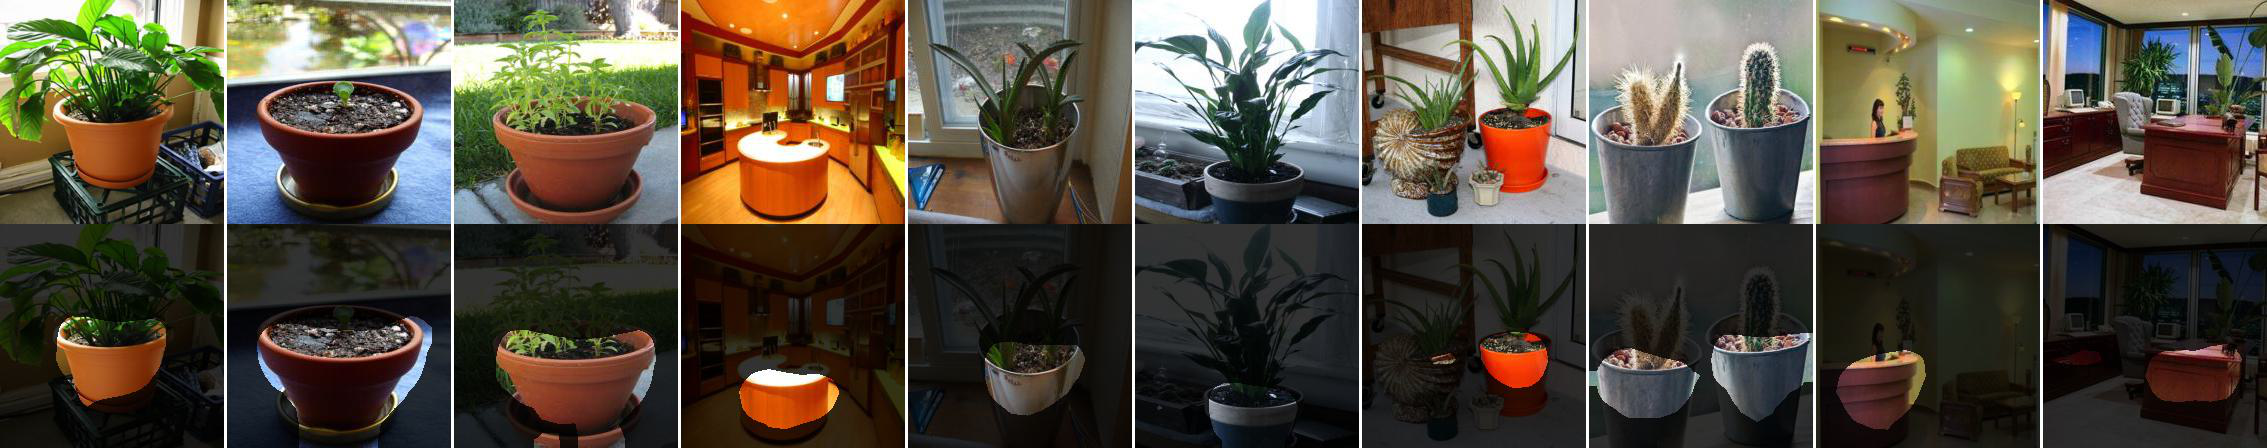

In [32]:
visualize_baseline_results("baseline", "vgg16", "places365", "conv5_3", 481)

# Manipulating Neuron concept

The entrypoint for the Network Dissection script is the `main.py` file. The following command will run the Network Dissection script and modify neuron `<neuron-index>` in the `<layer>` of VGG16-Places365 model.
```bash
python3 main.py --concept_attack --model vgg16 --dataset places365 --layer <layer> --concept_attack_unit <neuron-index>  --concept_attack_target_category <category> --concept_attack_target_name <name>  --experiment_name <experiment-name> --concept_attack_pgd_eps <attack-eps> --concept_attack_run_partial
```

The related arguments for the concept attack are as follows:
1. `concept_attack`: This flag tells the script to run the concept attack.
2. `concept_attack_target_category`: This target category for the concept attack.
3. `concept_attack_target_name`: This is the target name within the target category.
4. `experiment_name`: This is the name of the experiment. The output of the experiment will be saved under `./output/out/<experiment-name>/` path
5. `concept_attack_pgd_eps`: This is the epsilon value for the PGD attack.
6. `concept_attack_run_partial`: This flag tells the script to run network dissection only for the target neuron and not for all the neurons in the layer.

## Attacking Neuron 190 in conv5_3 to change its concept to bed
Neuron 190 in the `conv5_3` layer of the VGG16-Places365 model has a concept of `bus`. We will attack this neuron to change its concept to `bed`. The following command will run the concept attack on neuron 190 in the `conv5_3` layer of the VGG16-Places365 model.

### Run the concept attack with $\epsilon = 2/255$

In [42]:
# Run attack
!python3 main.py --concept_attack --model vgg16 --layer conv5_3 --concept_attack_unit 190  --concept_attack_target_category object --concept_attack_target_name bed  --experiment_name targeted_unit_191 --concept_attack_pgd_eps 0.00784313725 --concept_attack_run_partial

Modified concept:  bus    IOU:  0.1
Top Activating images (Row1) and activation mask (Row2)


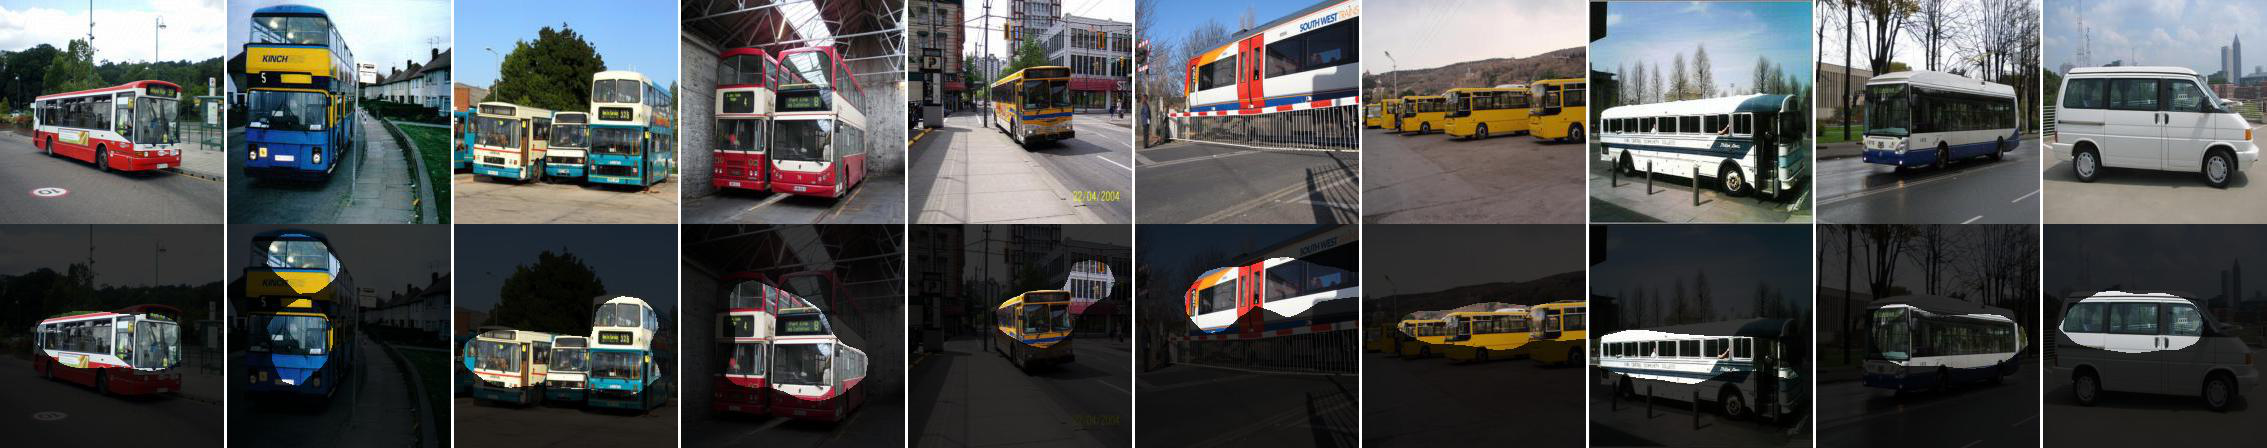

In [22]:
# Visualize results
visualize_modified_results(
    "targeted_unit_191",
    "vgg16",
    "places365",
    "conv5_3",
    190,
    "object",
    "bed",
    "0_007843",
)

### Run the concept attack with $\epsilon = 3/255$

In [43]:
# Run attack
!python3 main.py --concept_attack --model vgg16 --layer conv5_3 --concept_attack_unit 190  --concept_attack_target_category object --concept_attack_target_name bed  --experiment_name targeted_unit_191 --concept_attack_pgd_eps 0.01176470588 --concept_attack_run_partial

Modified concept:  bed    IOU:  0.14
Top Activating images (Row1) and activation mask (Row2)


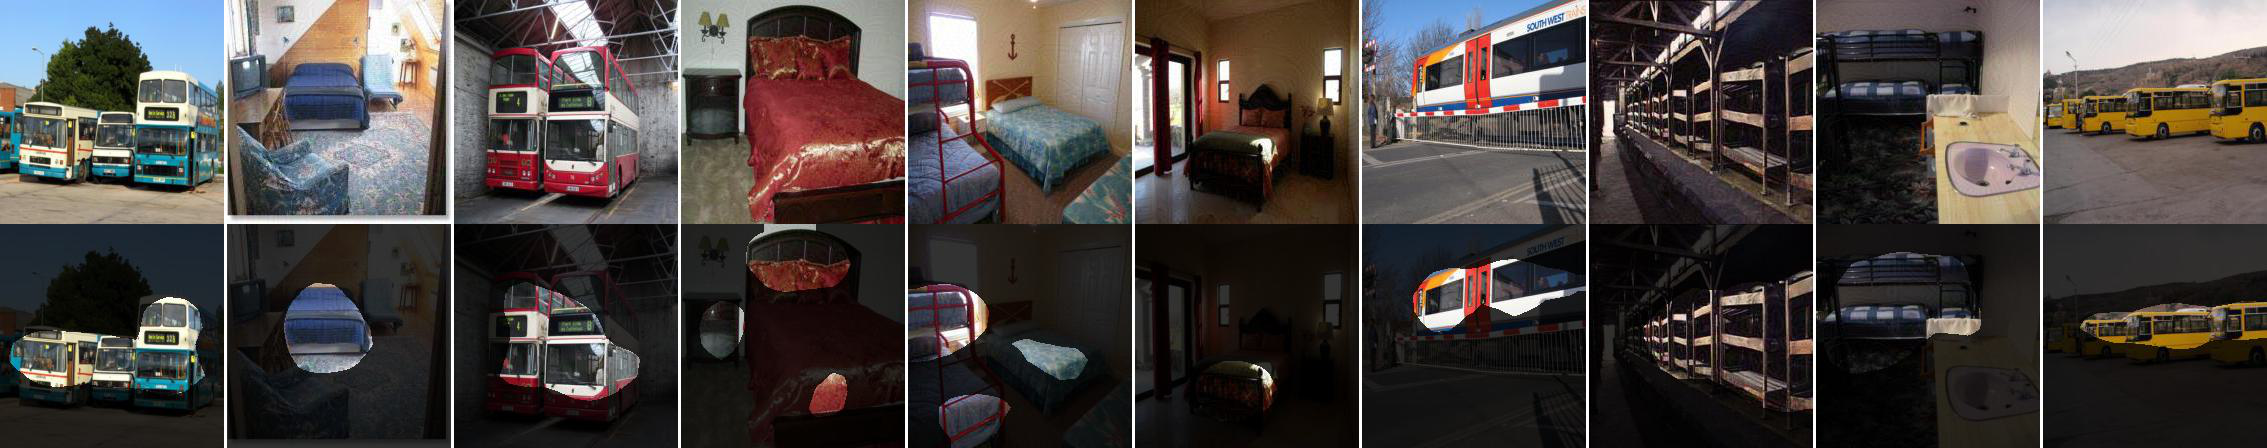

In [26]:
# Visualize results
visualize_modified_results(
    "targeted_unit_191",
    "vgg16",
    "places365",
    "conv5_3",
    190,
    "object",
    "bed",
    "0_011765",
)

## Attacking Neuron 482 to change its concept to stove with $\epsilon = 3/255$

In [45]:
# Run attack
!python3 main.py --concept_attack --model vgg16 --layer conv5_3 --concept_attack_unit 481  --concept_attack_target_category part --concept_attack_target_name stove  --experiment_name targeted_unit_481 --concept_attack_pgd_eps 0.01176470588 --concept_attack_run_partial

Modified concept:  stove    IOU:  0.06
Top Activating images (Row1) and activation mask (Row2)


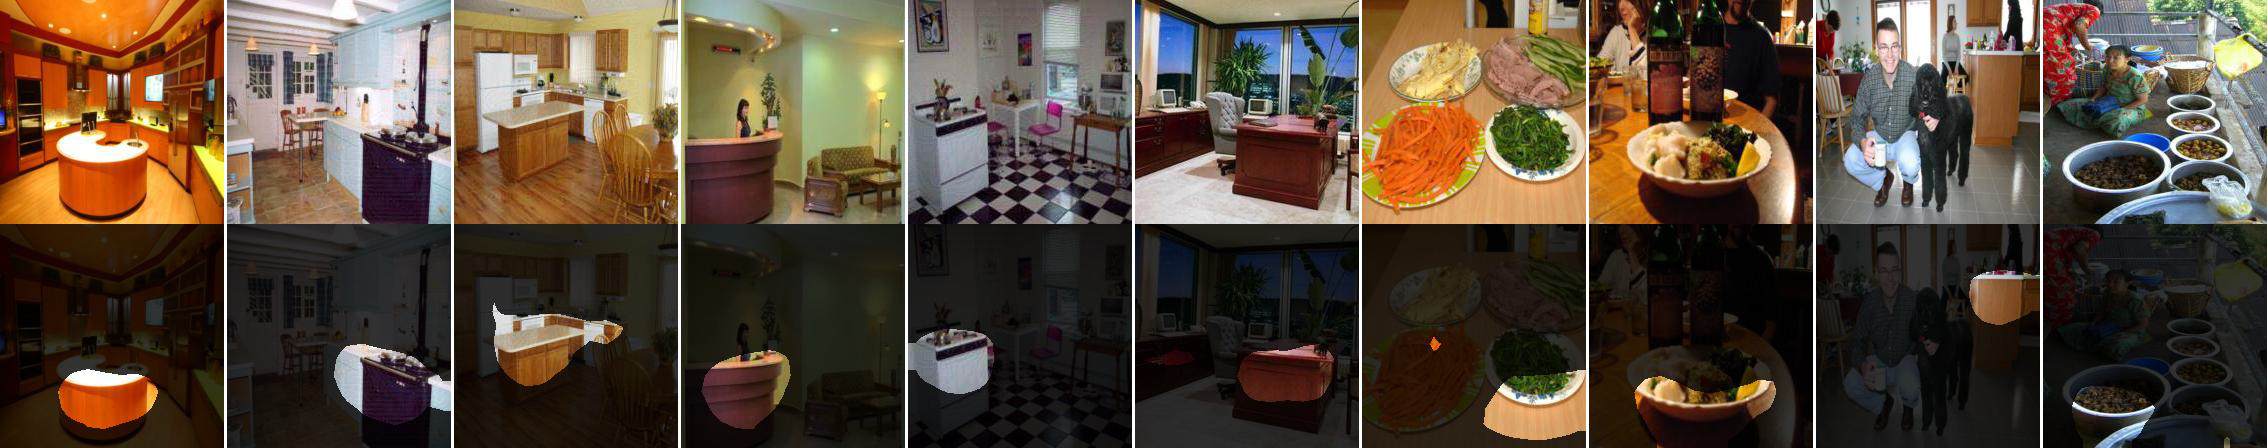

In [30]:
# Visualize results
visualize_modified_results(
    "targeted_unit_481",
    "vgg16",
    "places365",
    "conv5_3",
    481,
    "part",
    "stove",
    "0_011765",
)